# Bayesian Inference for Accelerated Randomized Benchmarking

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from math import pi

#Import Qiskit classes
import qiskit
from qiskit.tools.monitor import job_monitor
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error
from qiskit import  QuantumRegister, QuantumCircuit

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

import copy
import time

# import the bayesian packages
import pymc3 as pm
import arviz as az

import bayesian_fitter as bf

In [2]:
# initialize the Bayesian extension
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Parameters of the RB Run <a name='select_params_RB'></a>


- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In [3]:
RB_process = "2_Q RB" #"3_Q RB" # choice from "2_Q RB" or "3_Q RB"
Gate_under_study = "CX"
# "2-3_Q RB" not used in this demo
if RB_process in ["3_Q RB","2-3_Q RB"] : 
    #Number of qubits
    nQ = 3
    #There are 3 qubits: Q0,Q1,Q2.
    #2Q RB on Q0,Q2 and 1Q RB on Q1
    rb_pattern = [[1,2],[3]] # because 3 qubits
    #Do three times as many 1Q Cliffords    
    length_multiplier = [1,3]
    #Interleaved Clifford gates (2-qubits and 1-qubit)
    interleaved_gates = [['cx 0 1'],['x 2']]

else:
    #Number of qubits
    nQ = 2
    #There are 2 qubits: Q0,Q1.
    #2Q RB Q0,Q1
    rb_pattern = [[1,2]]
    length_multiplier = 1
    interleaved_gates = [['cx 0 1']]    

In [4]:
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)

#Number of seeds (random sequences)
nseeds=8
#retrieve_list=ibmq_belem_list
#retrieve_list=ibmq_lima_list
retrieve_list=[] # if you want a new runs on hardware or if no hardware
if retrieve_list != []:
    nseeds = len(retrieve_list)

In [27]:
qregs_02 = QuantumRegister(2)
circ_02 = QuantumCircuit(qregs_02, name='circ_02')

circ_02.h(qregs_02[1])
#circ_02.cx(qregs_02[1], qregs_02[0])
circ_02.cx(qregs_02[0], qregs_02[1])
#circ_02.cx(qregs_02[1], qregs_02[0])
circ_02.h(qregs_02[1])
circ_02.draw()

q6694_0: ───────■───────
         ┌───┐┌─┴─┐┌───┐
q6694_1: ┤ H ├┤ X ├┤ H ├
         └───┘└───┘└───┘

In [6]:
qregs_1 = QuantumRegister(1)
circ_1 = QuantumCircuit(qregs_1, name='circ_1')
circ_1.x(qregs_1[0]) # booptrap! WIP!
circ_1.draw()

┌───┐
q1_0: ┤ X ├
      └───┘

## Generate the RB sequences <a name='gen_RB_seq'></a>

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

In [7]:
rb_opts = {}
rb_opts['rand_seed'] = 61946
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
#rb_opts['align_cliffs'] = True
if RB_process in ["3_Q RB","2-3_Q RB"]:
    rb_opts['interleaved_elem'] = [circ_02, circ_1]
if RB_process == "2_Q RB":
     rb_opts['interleaved_elem'] = [circ_02]
rb_original_circs, xdata, rb_interleaved_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [8]:
#Original RB circuits
print (rb_original_circs[0][0])

                                                                           »
qr_0: ─────────────────────────────────────────────────────────────────────»
      ┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░ ┌─────┐┌───┐     ┌───┐»
qr_1: ┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░─┤ SDG ├┤ H ├──■──┤ H ├»
      └┬───┬┘├───┤┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤ ░ ├─────┤├───┤┌─┴─┐├───┤»
qr_2: ─┤ Z ├─┤ H ├┤ X ├┤ SDG ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ SDG ├┤ H ├┤ X ├┤ H ├»
       └───┘ └───┘└───┘└─────┘└───┘└───┘└───┘└───┘ ░ └─────┘└───┘└───┘└───┘»
cr: 2/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                                
«qr_0: ──────────────────────────
«      ┌───┐     ┌───┐┌───┐┌─┐   
«qr_1: ┤ S ├──■──┤ H ├┤ S ├┤M├───
«      ├───┤┌─┴─┐├───┤├───┤└╥┘┌─┐
«qr_2: ┤ S ├┤ X ├┤ H ├┤ Z ├─╫─┤M├
«      └───┘└───┘└───┘└───┘ ║ └╥┘
«cr: 2/═════════════════════╩══╩═
«                           0  1 


In [9]:
#Interleaved RB circuits
print (rb_interleaved_circs[0][0])

                                                                              »
qr_0: ────────────────────────────────────────────────────────────────────────»
      ┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░       ░      ┌─────┐┌───┐»
qr_1: ┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░───■───░───■──┤ SDG ├┤ H ├»
      └┬───┬┘├───┤┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐├─────┤├───┤»
qr_2: ─┤ Z ├─┤ H ├┤ X ├┤ SDG ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ X ├─░─┤ X ├┤ SDG ├┤ H ├»
       └───┘ └───┘└───┘└─────┘└───┘└───┘└───┘└───┘ ░ └───┘ ░ └───┘└─────┘└───┘»
cr: 2/════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                          
«qr_0: ────────────────────────────────────
«           ┌───┐┌───┐     ┌───┐┌───┐┌─┐   
«qr_1: ──■──┤ H ├┤ S ├──■──┤ H ├┤ S ├┤M├───
«      ┌─┴─┐├───┤├───┤┌─┴─┐├───┤├───┤└╥┘┌─┐
«qr_2: ┤ X ├┤ H ├┤ S ├┤ X ├┤ H ├┤ Z ├─╫─┤M├
«      └───┘└───

### Determine hardware for noise model simulation or real device experiment

In [10]:
from qiskit import IBMQ
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_paris') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-internal', group='deployed', project='d

In [11]:
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
shots = 2**10
retrieve_list=[] # nothing to retrieve

In [12]:
device = provider.get_backend('ibmq_santiago') # type here hardware backend
hardware = device.name()
properties = device.properties()
coupling_map = device.configuration().coupling_map
backend = device
noise_model = None

In [13]:
# use a noise model corresponding to the chosen real device backend
#hardware = device.name() 
#backend = Aer.get_backend('qasm_simulator')
#noise_model = NoiseModel.from_backend(properties)

 # Execute the RB sequences

In [14]:
original_result_list, original_transpile_list = bf.get_and_run_seeds(rb_circs=rb_original_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Job Status: job has successfully run
Compiling seed 1
Runing seed 1
Job Status: job has successfully run
Compiling seed 2
Runing seed 2
Job Status: job has successfully run
Compiling seed 3
Runing seed 3
Job Status: job has successfully run
Compiling seed 4
Runing seed 4
Job Status: job has successfully run
Compiling seed 5
Runing seed 5
Job Status: job has successfully run
Compiling seed 6
Runing seed 6
Job Status: job has successfully run
Compiling seed 7
Runing seed 7
Job Status: job has successfully run
Finished  Jobs


In [15]:
interleaved_result_list, interleaved_transpile_list = bf.get_and_run_seeds(rb_circs=rb_interleaved_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Job Status: job has successfully run
Compiling seed 1
Runing seed 1
Job Status: job has successfully run
Compiling seed 2
Runing seed 2
Job Status: job has successfully run
Compiling seed 3
Runing seed 3
Job Status: job has successfully run
Compiling seed 4
Runing seed 4
Job Status: job has successfully run
Compiling seed 5
Runing seed 5
Job Status: job has successfully run
Compiling seed 6
Runing seed 6
Job Status: job has successfully run
Compiling seed 7
Runing seed 7
Job Status: job has successfully run
Finished  Jobs


### Calculate the interleaved gate error fidelity

From the values of $\alpha$ and $\alpha_C$ we obtain the gate error of the interleaved Clifford $c$, and $r_C=1-$(average gate fidelity of the interleaved Clifford $C$), is estimated by:
$$ EPC^{est} = r_C^{est} = \frac{(2^n-1)(1-\alpha/\alpha_C)}{2^n}$$
and must lie in the range given by certain systematic error bounds: 
$$[r_C^{est}-E,r_C^{est}+E]$$ 
for each of the patterns.

In [16]:
###### Create the original and interleaved RB fitter
original_rb_fit = rb.RBFitter(original_result_list, xdata, rb_opts['rb_pattern'])
interleaved_rb_fit = rb.RBFitter(interleaved_result_list, xdata, rb_opts['rb_pattern'])

###### mkd
alpha_f = original_rb_fit._fit[0]['params'][1] 
alphC_f =  interleaved_rb_fit._fit[0]['params'][1] 
alpha_f_err = original_rb_fit._fit[0]['params_err'][1] 
alphC_f_err =  interleaved_rb_fit._fit[0]['params_err'][1] 
epc_est_f = 3*(1 - alphC_f/alpha_f)/4
epc_est_f_err = 3*(alphC_f/alpha_f)/4*(np.sqrt(alpha_f_err**2 + alphC_f_err**2))

In [17]:
#Calculate the joint fitter
joint_rb_fit = rb.InterleavedRBFitter(original_result_list, interleaved_result_list, xdata, rb_opts['rb_pattern'])

##  Bayesian inference

###  Accelerated RB

model: [equation 5 in this paper](https://arxiv.org/abs/1404.5275) 

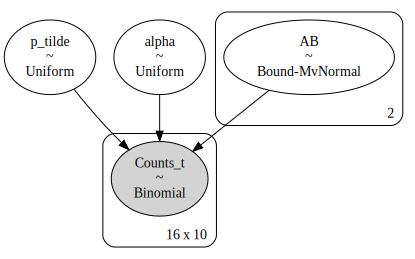

In [18]:
m_gates, Y1, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    bf.obtain_priors_and_data_from_fitter(rbfit = original_rb_fit, nCliffs=nCliffs, shots=shots, printout = False) 
_, Y2, _, _, _, _, _, _ =\
    bf.obtain_priors_and_data_from_fitter(rbfit = interleaved_rb_fit, nCliffs=nCliffs, shots=shots, printout = False)

Y = np.vstack((Y1,Y2))
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))

tilde = bf.get_bayesian_model("tilde",Y=Y,shots=shots,m_gates=m_gates, alpha_ref=alpha_ref, mu_AB=mu_AB,cov_AB=cov_AB,RvsI=RvsI,IvsR=IvsR)
pm.model_to_graphviz(tilde)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_tilde, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 32 seconds.


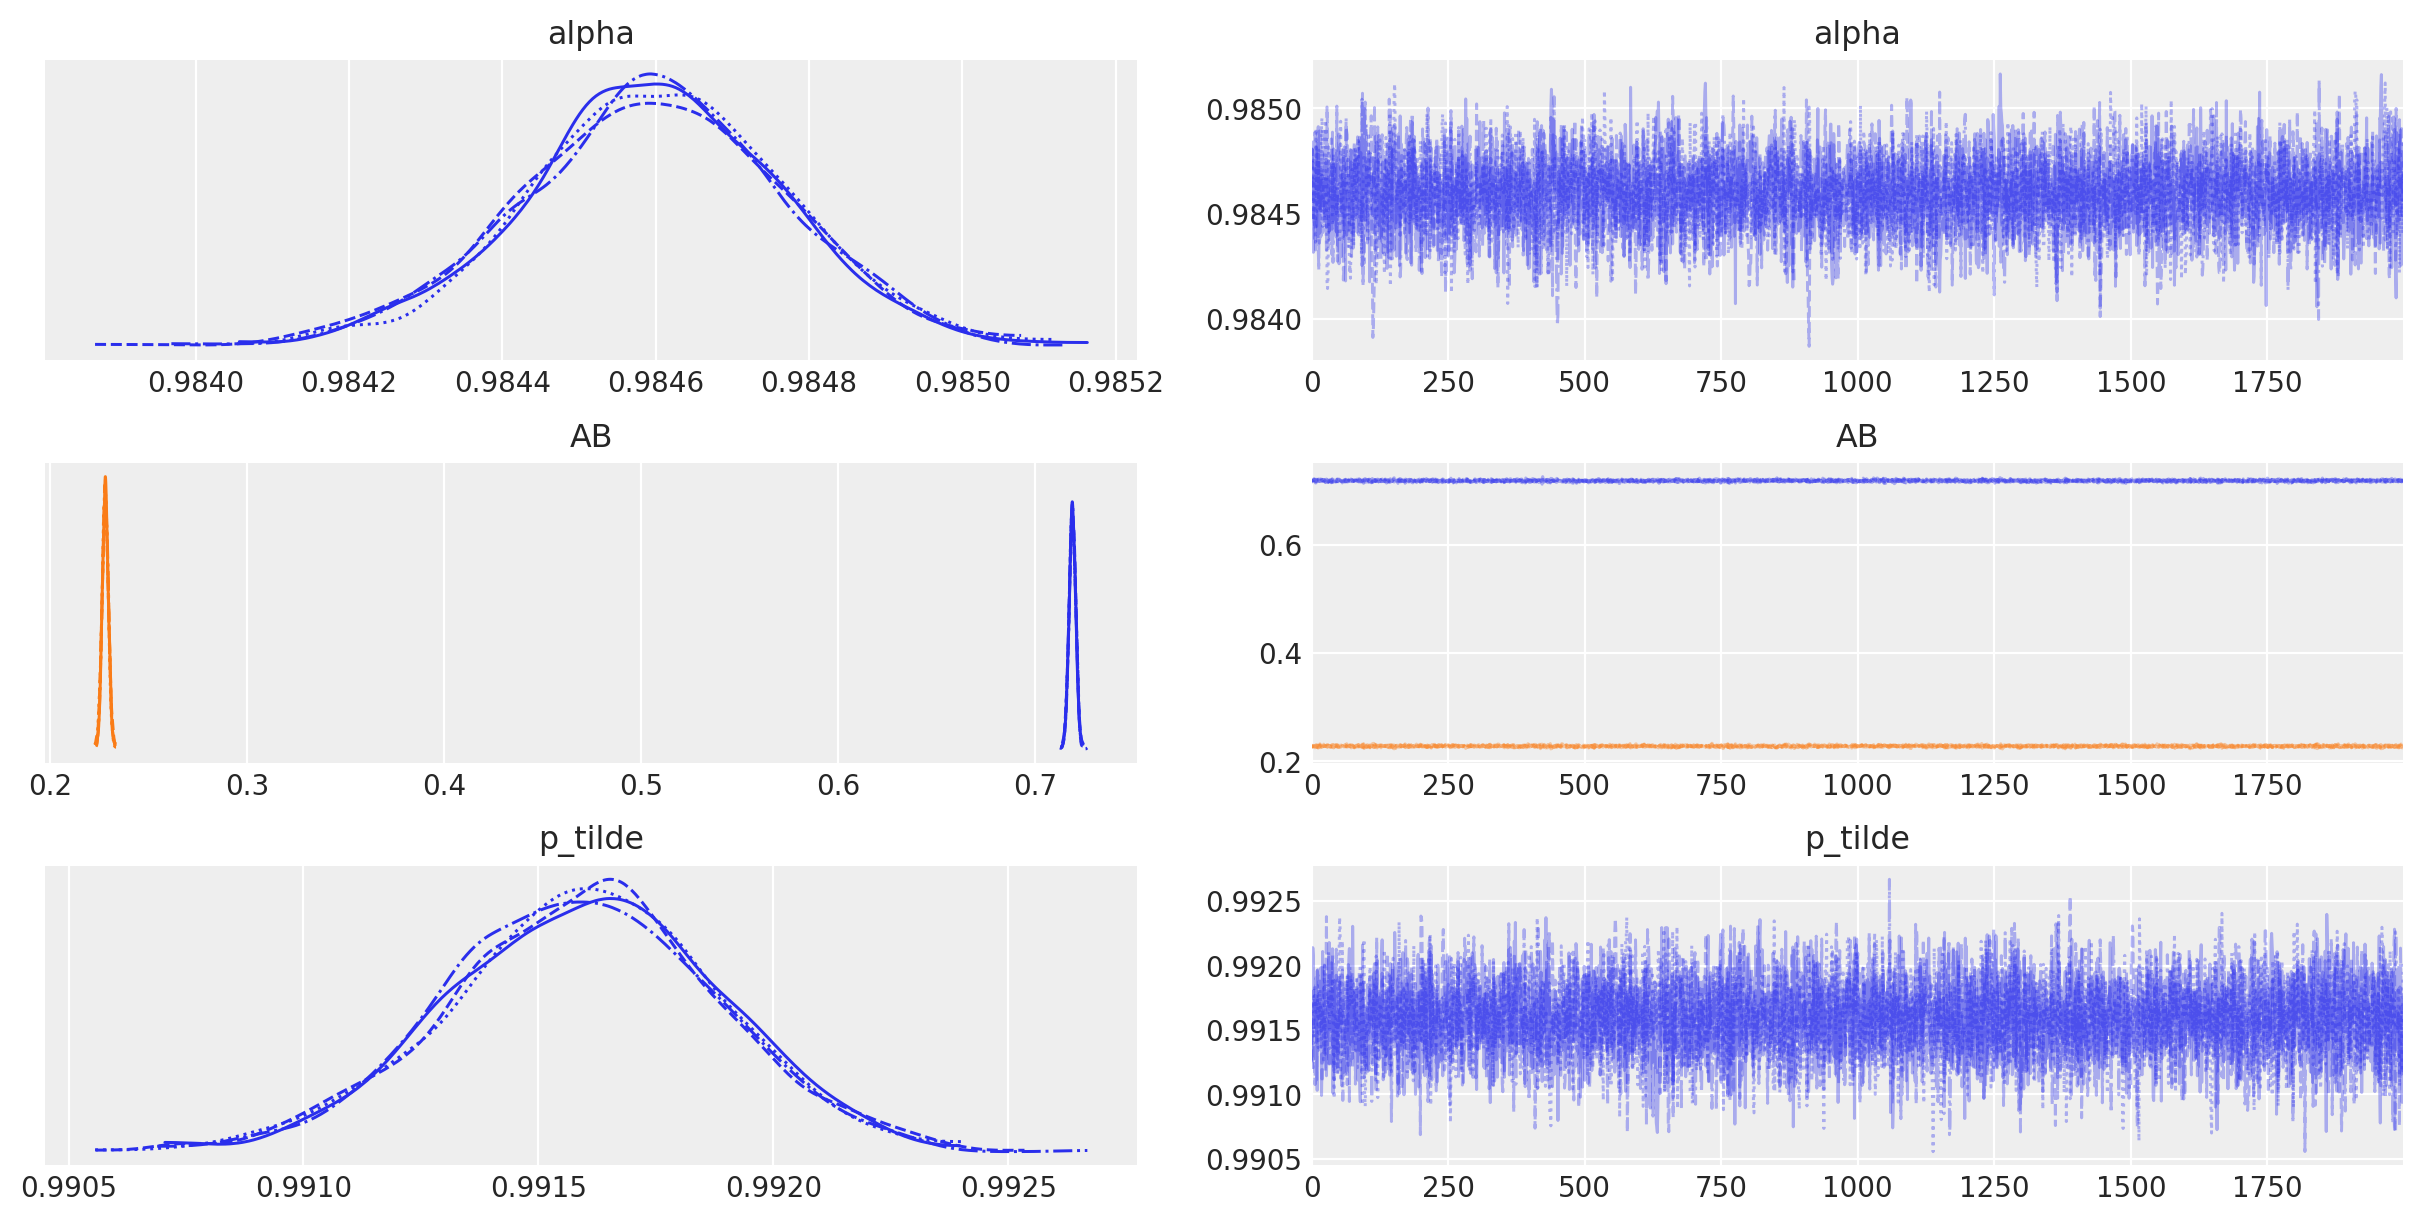

In [19]:
trace_t = bf.get_trace(tilde)

In [20]:
azt_summary = bf.get_summary(tilde, trace_t)
azt_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9846,0.0002,0.9843,0.9849,0.0,0.0,5134.8623,4462.9043,1.0007
AB[0],0.7190,0.0017,0.7158,0.7222,0.0,0.0,5680.5001,4966.9956,1.0003
AB[1],0.2279,0.0016,0.2249,0.2308,0.0,0.0,4710.0993,4229.3885,1.0002
p_tilde,0.9916,0.0003,0.9910,0.9921,0.0,0.0,5461.0989,5485.6406,1.0005


# Final comparison

In [21]:
# for refering the interleaved gate in the title of the graphs
intl_g=str(interleaved_gates[0][0][0:2])+str(rb_pattern[0][0:2])
if RB_process in ["3_Q RB","2-3_Q RB"] :
    intl_g=intl_g+"<"+str(interleaved_gates[1][0][0:1]+str(rb_pattern[1][0:2]))

In [22]:
# calibration made april 21, 2021 , 12AM 
epc_calib = 5.453E-3 # enter here the read calibration error of the device, 0.0 if None WIP

epc_est_fitter = joint_rb_fit.fit_int[0]["epc_est"]
epc_est_fitter_err = joint_rb_fit.fit_int[0]["epc_est_err"]

epc_est_a =3/4*(1 - azt_summary['mean']['p_tilde'])
epc_est_a_err = 3/4* (azt_summary['sd']['p_tilde'])

print("      fitter   2xpooled  calibration")
print("EPC   {0:.5f}  {1:.5f}   {2:.5f} ".format(epc_est_fitter,  epc_est_a, epc_calib))
print("ERROR {0:.5f}  {1:.5f}      --- ".format(epc_est_fitter_err, epc_est_a_err))

      fitter   2xpooled  calibration
EPC   0.00703  0.00630   0.00545 
ERROR 0.00055  0.00022      --- 


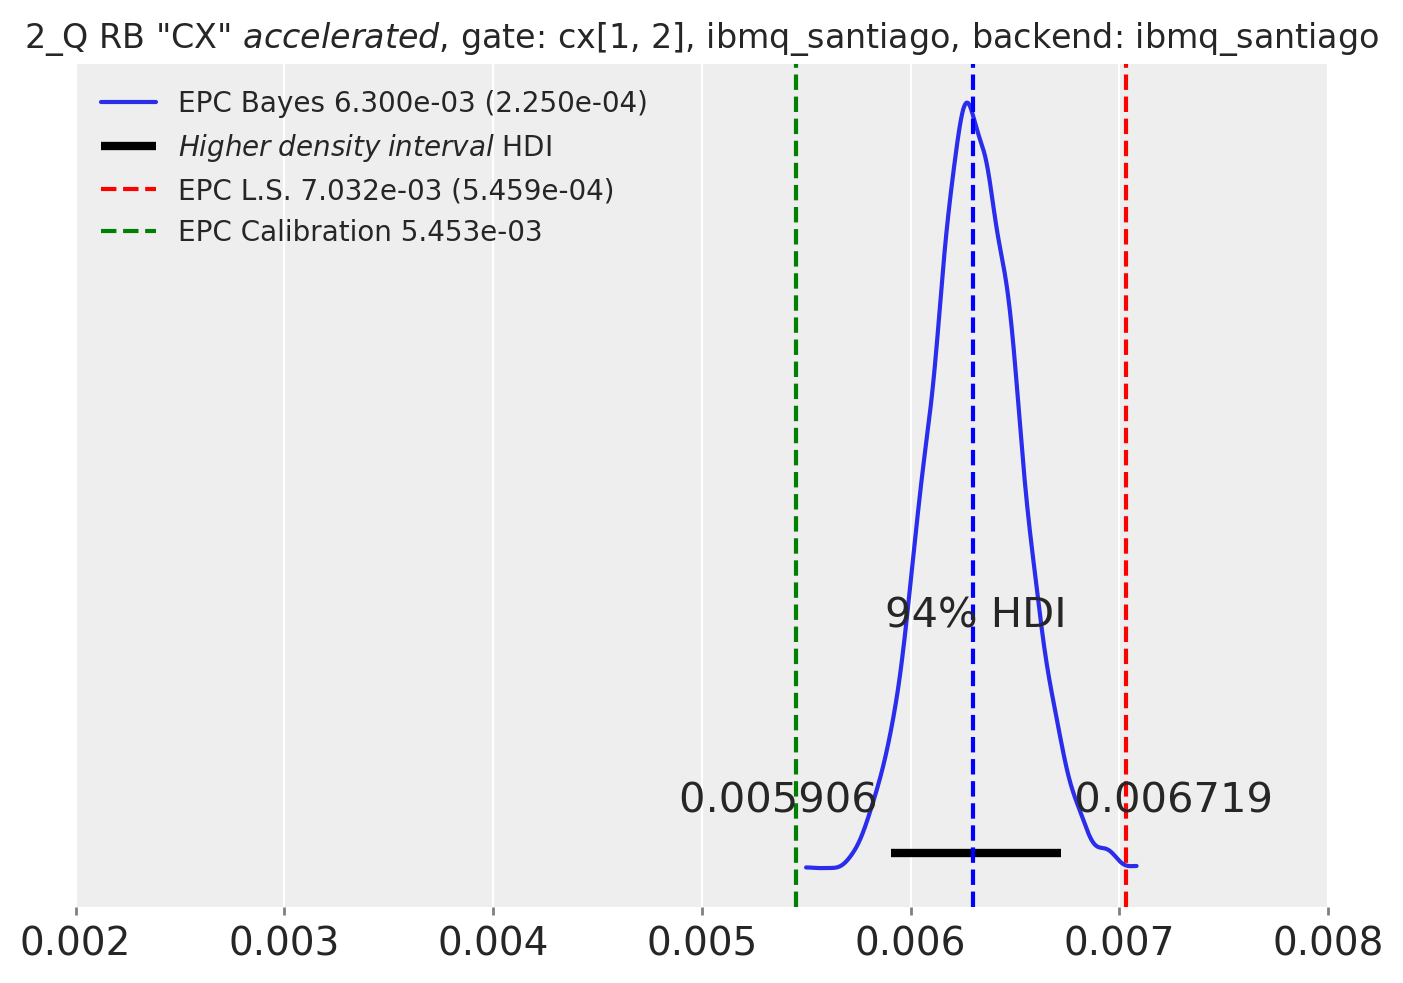

In [23]:
import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

with tilde:
        ax = az.plot_posterior(trace_t,  var_names=['p_tilde'], round_to=4, point_estimate=None, 
                          transform =  bf.alpha_to_EPC)
        ax.set_xlim(0.002, 0.008)
        plt.axvline(x=epc_est_fitter,color='red',ls="--")
        if epc_calib > 0.0:
            plt.axvline(x=epc_calib,color='green',ls="--")
        plt.axvline(x=epc_est_a,color='blue',ls="--")
        plt.title(RB_process + ' \"' + Gate_under_study + '\" $accelerated$, gate: ' + intl_g\
                  +", "+hardware+', backend: '+backend.name(),
               fontsize=12)
        Bayes_legend ="EPC Bayes {0:1.3e} ({1:1.3e})".format(epc_est_a, epc_est_a_err)
        Fitter_legend ="EPC L.S. {0:1.3e} ({1:1.3e})".format(epc_est_fitter, epc_est_fitter_err)                                                        
        Cal_legend ="EPC Calibration {0:1.3e}".format(epc_calib)
        if epc_calib > 0.0:
            plt.legend((Bayes_legend, "$Higher\; density\; interval$ HDI",
                        Fitter_legend,Cal_legend), fontsize=10 )
        else: 
            plt.legend((Bayes_legend, "$Higher\; density\; interval$ HDI",
                        Fitter_legend), fontsize=10 )

Text(0.5, 1.0, '2_Q RB "CX" $accelerated$, gate: cx[1, 2], ibmq_santiago, backend: ibmq_santiago')

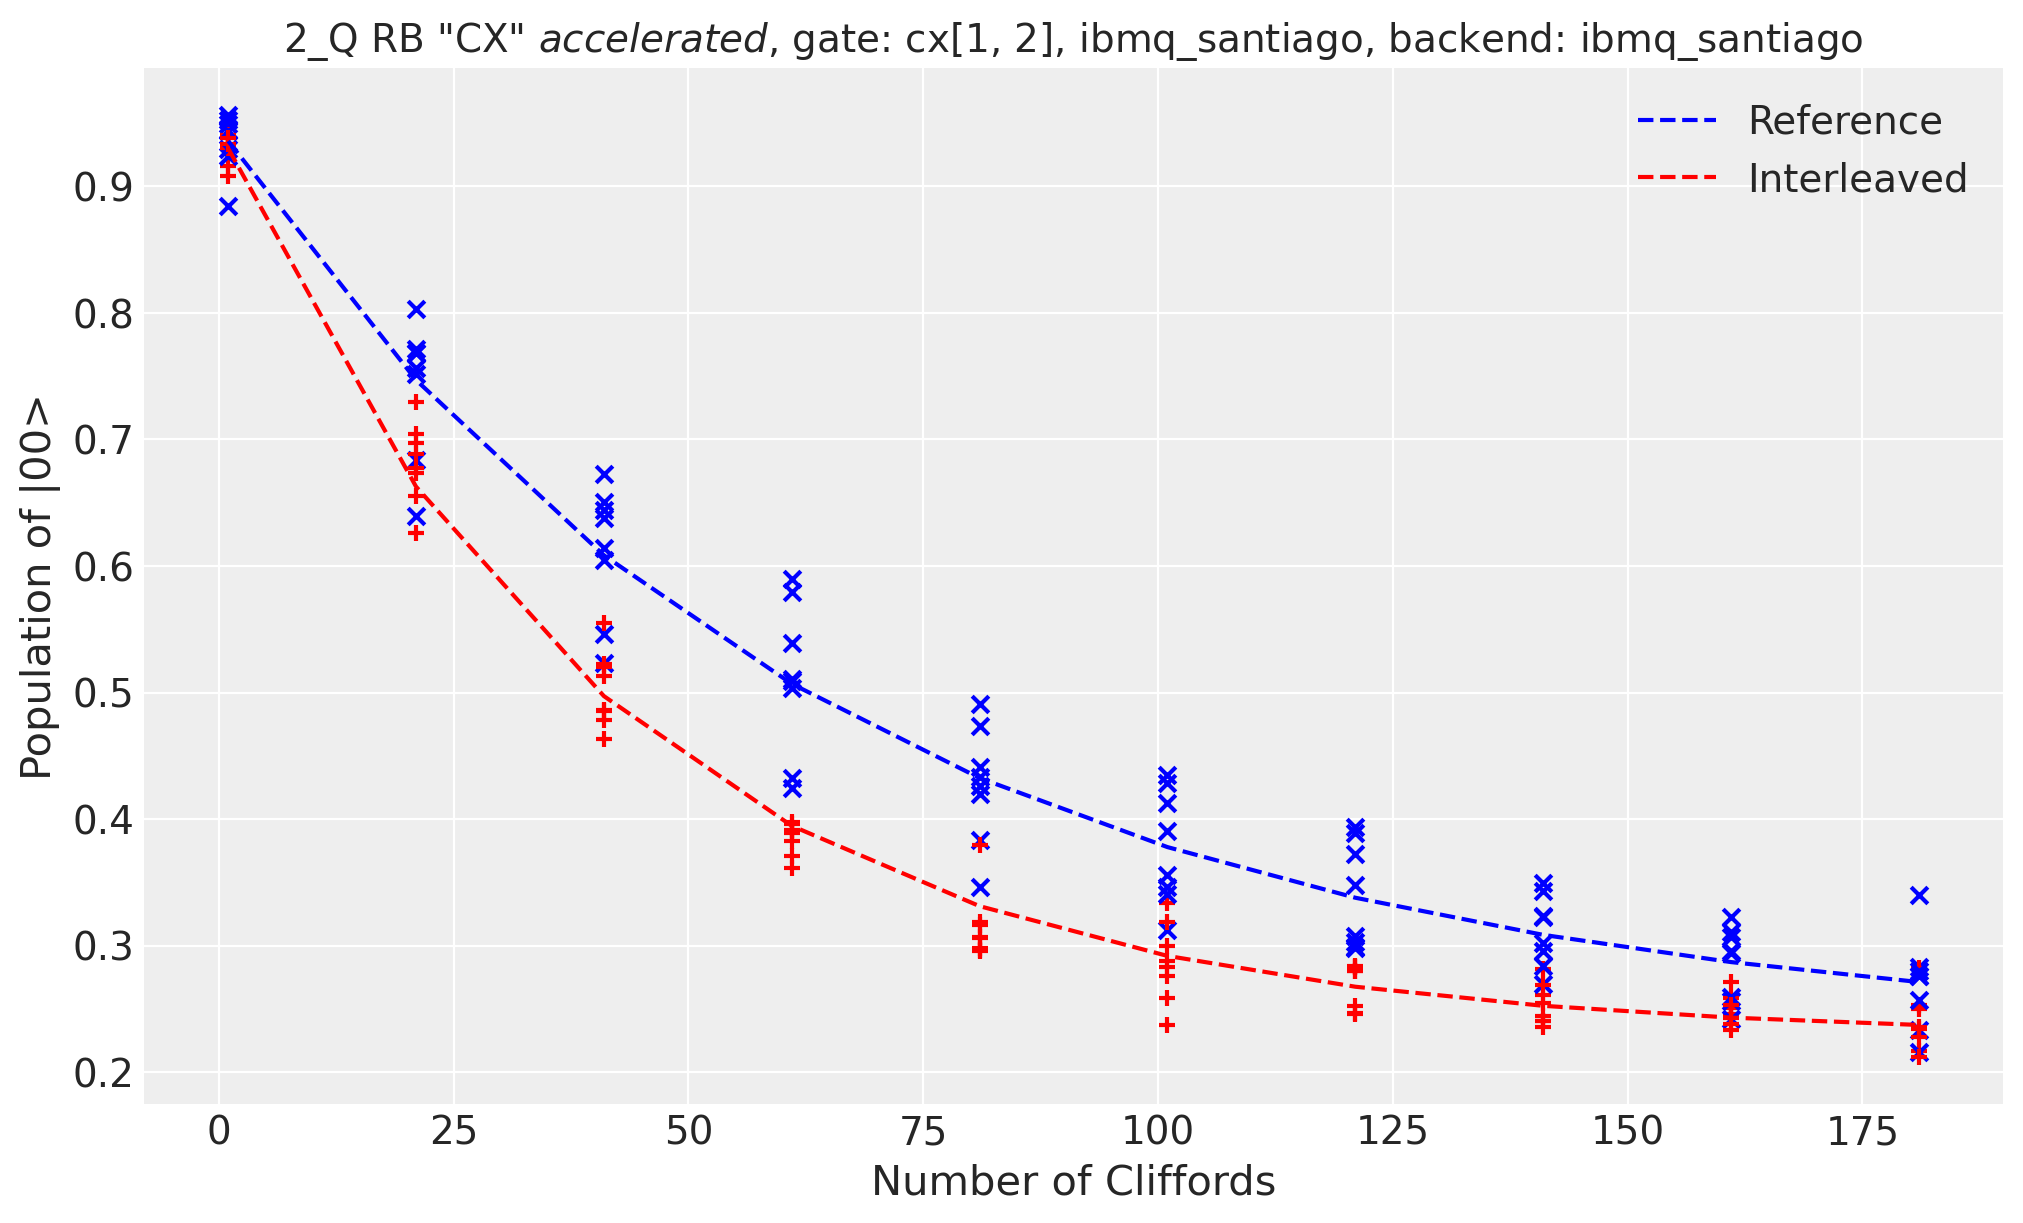

In [24]:
import matplotlib.pyplot as plt # seems we need to reimport for replot WIP

#fig, plt = plt.subplots(1, 1, sharex=True, figsize=(10, 6))
fig, plt = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

plt.set_ylabel("Population of |00>")
plt.set_xlabel("Number of Cliffords")

for i_seed in range(nseeds):
    plt.scatter(m_gates, Y1[i_seed,:]/shots, label = "data", marker="x",color="b")
    plt.scatter(m_gates, Y2[i_seed,:]/shots, label = "data", marker="+",color="r")
plt.plot(m_gates,azt_summary['mean']['AB[0]']*azt_summary['mean']['alpha']**m_gates+\
          azt_summary['mean']['AB[1]'],'--',color="b")
plt.plot(m_gates,azt_summary['mean']['AB[0]']*(azt_summary['mean']['alpha']*azt_summary['mean']['p_tilde'])**\
          m_gates+azt_summary['mean']['AB[1]'],'--',color="r")

plt.legend(("Reference",
             "Interleaved"))

plt.set_title(RB_process + ' \"' + Gate_under_study + '\" $accelerated$, gate: ' + intl_g\
                  +", "+hardware+', backend: '+backend.name(),
               fontsize=14)

In [25]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed May 05 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

IPython: 7.18.1
pymc3  : 3.11.2
qiskit : 0.25.2
arviz  : 0.11.2
numpy  : 1.19.1

Watermark: 2.2.0

